In [1]:
from bpr_model import BPR
from dataloader import AmazonDataset
from training import TrainIterater
from evaluate import Evaluater

import time
import optuna
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
dataset = AmazonDataset('./data')

early stopping するか？

In [6]:
# ハイパラ
# embed_dim
# batch_size
# weight_decay, lr, warmup, lr_decay_every, lr_decay_rate
# optimizer
def time_since(runtime):
    mi = int(runtime / 60)
    sec = int(runtime - mi * 60)
    return (mi, sec)

def objective(trial):
    start = time.time()
    
    embedding_dim = trial.suggest_discrete_uniform('embedding_dim', 16, 64, 16)
    bpr = BPR(int(embedding_dim), len(dataset.user_list), len(dataset.item_list)).to(device)
    
    batch_size = trial.suggest_discrete_uniform('batch_size', 64, 256, 64)
    iterater = TrainIterater(batch_size=int(batch_size))
    
    lr= trial.suggest_loguniform('lr', 1e-5, 1e-2)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
    warmup = trial.suggest_int('warmup', 100, 500)
    #warmup = trial.suggest_int('warmup', 1, 5)
    lr_decay_every = trial.suggest_int('lr_decay_every', 1, 5)
    lr_decay_rate = trial.suggest_uniform('lr_decay_rate', 0.5, 1)
    
    score =iterater.iterate_epoch(bpr, lr=lr, epoch=3000, weight_decay=weight_decay, warmup=warmup,
                           lr_decay_rate=lr_decay_rate, lr_decay_every=lr_decay_every, eval_every=100)
    
    mi, sec = time_since(time.time() - start)
    print('{}m{}sec'.format(mi, sec))
    
    return -1 * score

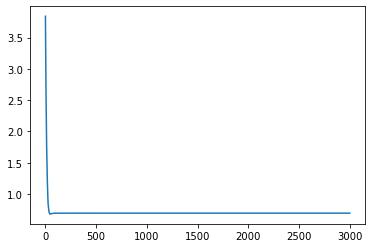

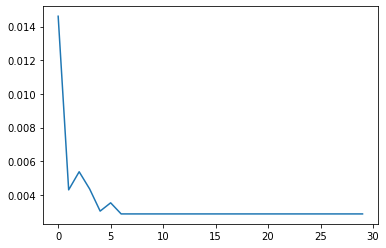

23m31sec


[I 2020-07-05 11:21:27,717] Finished trial#0 with value: -0.0028715261065983023 with parameters: {'embedding_dim': 48.0, 'batch_size': 256.0, 'lr': 0.0005580773785809941, 'weight_decay': 0.0055573635892448995, 'warmup': 412, 'lr_decay_every': 3, 'lr_decay_rate': 0.8713231022998477}. Best is trial#0 with value: -0.0028715261065983023.


In [ ]:
study = optuna.create_study()
study.optimize(objective, n_trials=20)

In [5]:
df = study.trials_dataframe() # pandasのDataFrame形式
df.to_csv('hyparams_result.csv')